In [1]:
import sys
sys.path.append("..\\scripts\\")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d
import mpol.constants as const
from mpol import coordinates

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json

plt.style.use("dark_background")

from utils import fits_to_tensor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_ct_g_220912024942")

In [79]:
# Just take the first spectral window: 
data = np.load("../../HTLup_continuum_full.npz")

u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]


# idx_inf= vis_per_spw[:-3].sum()
# idx_sup = vis_per_spw[:-2].sum()
# u = u[idx_inf:idx_sup]
# v = v[idx_inf:idx_sup]
# vis = vis[idx_inf:idx_sup]
# weight = weight[idx_inf:idx_sup]

uu = np.concatenate([u, u])
vv = np.concatenate([v, v])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, vis.imag])
weight_ = np.concatenate([weight, weight])


In [80]:
def grid(pixel_scale, img_size): 
    """Given a pixel scale and a number of pixels in image space, grid the associated Fourier space

    Args:
        pixel_scale (float): Pixel resolution (in arcsec)
        img_size (float/int): Size of the image 

    Returns:
        
    """

    # Arcsec to radians: 
    dl = pixel_scale * const.arcsec
    dm = pixel_scale * const.arcsec

    du = 1 / (img_size * dl) * 1e-3 # klambda
    dv = 1 / (img_size * dm) * 1e-3 # klambda

    u_min = -img_size//2 * du 
    u_max = img_size//2 * du 

    v_min = -img_size//2 * dv
    v_max = img_size//2 * dv

    u_edges = np.linspace(u_min, u_max, img_size + 1)
    v_edges = np.linspace(v_min, v_max, img_size + 1)

    return u_edges, v_edges

pixel_scale = 0.0015
img_size = 256
u_edges, v_edges = grid(pixel_scale = pixel_scale, img_size = img_size)


def plot_uv_coverage(u, v, grid = False): 
    # Plot the uv coverage, if grid = True, plot the associated grid
    plt.scatter(u, v, s=0.5, rasterized=True, linewidths=0.0, c="r")

    if grid: 
        for x_coord in u_edges: 
            plt.axvline(x = x_coord, color = "gray", linestyle = "-", alpha = 0.5)

        for y_coord in v_edges:
            plt.axhline(y =y_coord, color = "gray", linestyle = "-", alpha = 0.5)
        

    plt.xlim([u.min(), u.max()])
    plt.ylim([v.min(), v.max()])
    plt.gca().set_aspect("equal")
    

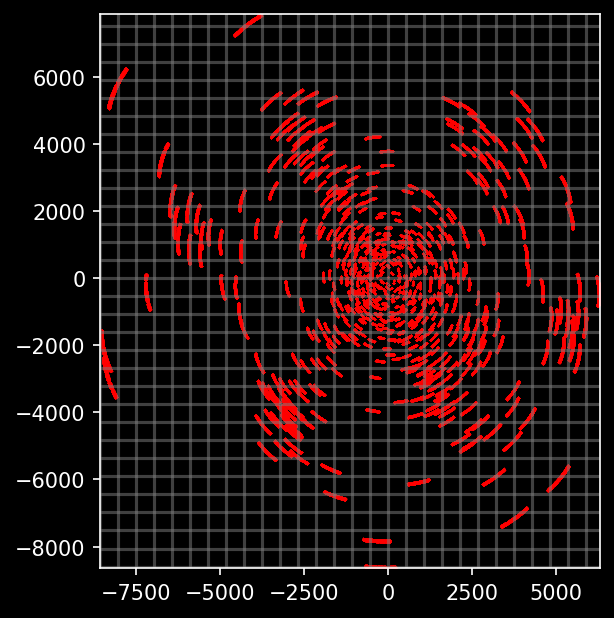

In [7]:
plot_uv_coverage(u, v, grid = True)

Some math: 
The weighted average is: 
$$
\langle x\rangle = \frac{\sum_{i=0}^N w_i x_i}{\sum_{i=0}^N w_i}
$$

The standard deviation for a weighted average is: 

$$
\langle \Delta x \rangle = \sqrt{\frac{\sum_{i=0}^N w_i (x_i - \langle x\rangle)^2}{\sum_{i=0}^N w_i}}
$$

Finally, to have the standard deviation ***_on the mean_*** we need to multiply the result above by $1/\sqrt{N}$

In [81]:
bin_x = u_edges
bin_y = v_edges


In [82]:
weight_vis_re = weight_ * vis_re
weight_vis_img = weight_ * vis_imag

def grid_mean(x, weight):
    weight_x = weight * x
    frac_up, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, weight_x, "sum", (bin_y, bin_x))
    frac_down, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, weight, "sum", (bin_y, bin_x))

    frac_up[frac_up == 0] = 0
    frac_down[frac_down==0] = 1e-16
    mean = frac_up / frac_down
    return mean

vis_gridded_re = grid_mean(vis_re, weight_)
vis_gridded_img = grid_mean(vis_imag, weight_)

In [83]:
vis_grid = vis_gridded_re + 1j * vis_gridded_img

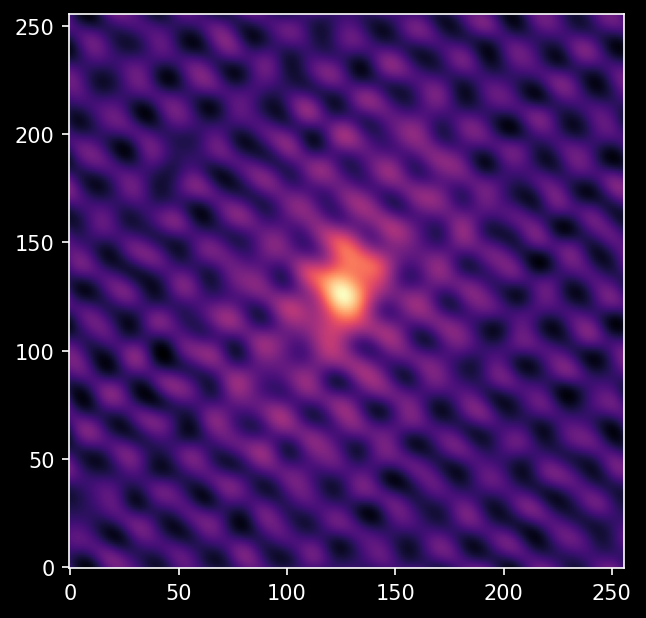

In [85]:
dirty_image = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(vis_grid)))[:, ::-1]
plt.imshow(dirty_image.real, cmap = "magma", origin = "lower")

In [58]:
mean.max()

1.0

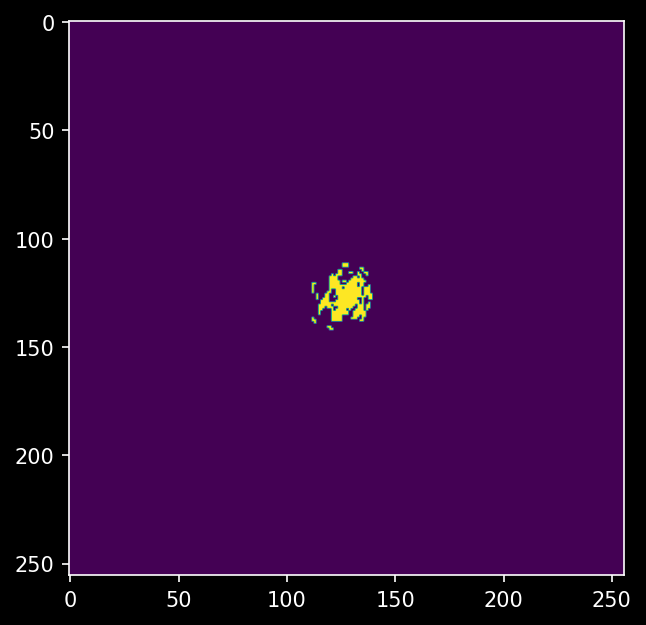

In [50]:
plt.imshow(frac_up.astype(bool))

In [5]:


weight_vis_re = weight * vis_re
vis_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_re, "mean", (bin_y, bin_x))
vis_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "mean", (bin_y, bin_x))

std_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_re, "std", (bin_y, bin_x))
std_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "std", (bin_y, bin_x))

count, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "count", (bin_y, bin_x))

vis_gridded_re[np.isnan(vis_gridded_re)] = 0
vis_gridded_img[np.isnan(vis_gridded_img)] = 0


std_gridded_re[np.isnan(std_gridded_re)] = 0
std_gridded_img[np.isnan(std_gridded_img)] = 0

vis_grid = vis_gridded_re + 1j * vis_gridded_img
vis_gridded_re, vis_gridded_img = np.fft.fftshift(vis_gridded_re).flatten(), np.fft.fftshift(vis_gridded_img).flatten()
std_gridded_re, std_gridded_img = np.fft.fftshift(std_gridded_re).flatten(), np.fft.fftshift(std_gridded_img).flatten()
count = np.fft.fftshift(count).flatten()

std_gridded_re /= (count + 1) ** 0.5
std_gridded_img /= (count + 1) ** 0.5
S_grid = std_gridded_re.astype(bool)


NameError: name 'vv' is not defined

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
dirty_beam = np.fft.fftshift(np.fft.ifft2(S_grid.reshape(img_size, img_size)))
dirty_image = np.fft.fftshift(np.fft.ifft2(vis_grid.reshape(img_size, img_size)))


im = axs[0].imshow(dirty_beam.real / dirty_beam.real.max(), cmap = "magma")
plt.colorbar(im, fraction = 0.046)

NameError: name 'plt' is not defined

In [30]:
S.shape

(65536,)

In [20]:
# Numpy to torch: 
S_cat = np.concatenate([S_grid, S_grid])
vis_gridded = np.concatenate([vis_gridded_re, vis_gridded_img])
std_gridded = np.concatenate([std_gridded_re, std_gridded_img])

S = torch.tensor(S_cat).to(device)
y = torch.tensor(vis_gridded, device = S.device)[S].to(device) * img_size
sigma_y = torch.tensor(std_gridded, device = S.device)[S].to(device) * img_size 


In [18]:
def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def link_function(x): 
    return (x+1) / 2 

def flip(x): 
    return x[:, ::-1]

In [87]:
k.shape

torch.Size([1, 65536])

In [99]:
k = k.reshape(img_size, img_size)

In [102]:
torch.flip(k, dims = (1,)).shape

torch.Size([256, 256])

In [96]:
torch.flip(k, dims = (1))

TypeError: flip(): argument 'dims' must be tuple of ints, not int

In [21]:
#sigma_y = 1e8 * torch.ones(len(y)).to(device)
#beta = 0
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t


def model(x):
    x = x.reshape(img_size, img_size) # for the FFT 
    x = link_function(x) # map from model unit space to real unit space
    x = torch.flip(x, dims = (1,))
    # Padding: 
    #pad_size = int((npix - img_size)/2)
    #x = torch.nn.functional.pad(x, (pad_size, pad_size, pad_size, pad_size)) 
    vis_full = ft(torch.fft.fftshift(x)).flatten() 
    vis_sampled = vis_full
    vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])
    return vis_sampled[S]


def log_likelihood(y, x, t, sigma_y):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = model(x)
    var = sigma(t) **2 / 2  + sigma_y**2
    log_prob = -0.5 * torch.sum((y - y_hat)**2 / var)
    return log_prob


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(y, x, t, sigma_y): 
    x = x.flatten(start_dim = 1) 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y)))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1) + score_likelihood(y, x, t, sigma_y) 

k = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(y, k, t, sigma_y)**2))**0.5)
print(score_posterior(k, t))

tensor(0.0017, device='cuda:0')
tensor([[-0.0007, -0.0034, -0.0004,  ..., -0.0052, -0.0039, -0.0011]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [8]:
def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return link_function(x_mean)

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return link_function(x_mean)

pred = 500
corr = 100
snr = 1e-2
#samples = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = img_size)
samples = pc_sampler(num_samples = 1, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

100%|██████████| 499/499 [03:48<00:00,  2.19it/s]


True


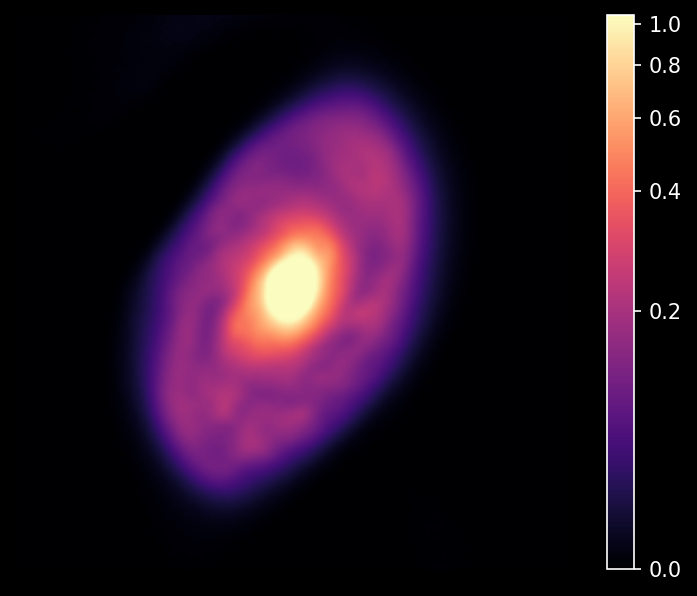

In [9]:
norm = True
save = False
n_images = len(samples)
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((samples[k]).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"../../images/HTLup_pad{img_size}norm.jpeg"
        norm = ImageNormalize(samples.cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    else: 
        save_path = f"../../images/HTLup_pad{img_size}nonorm.jpeg"
        norm = None
    plt.imshow((samples).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

In [27]:
sigma_y.mean()

tensor(3.4176e-07, dtype=torch.float64)

In [83]:
(std_gridded_re/(count+1)).mean()

3.2939683515150124e-07

In [84]:
vis_gridded_re.mean()

2.063231375540872e-05

In [7]:
def flip(x): 
    return x[:, ::-1]

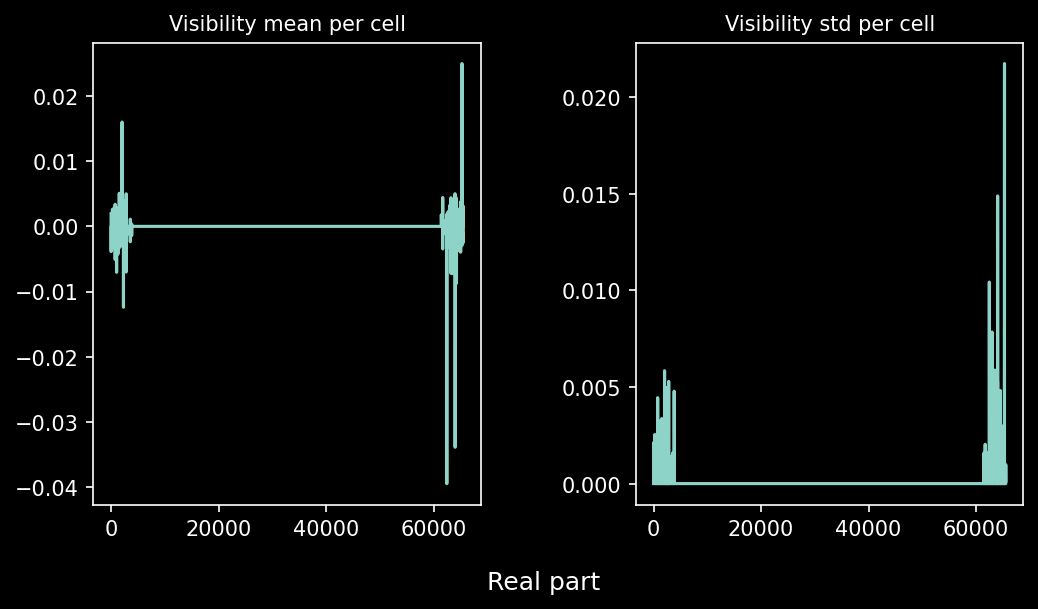

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (4*2, 4))
axs[0].plot(vis_gridded_img)
axs[0].set_title("Visibility mean per cell", size = 10)

axs[1].plot(std_gridded_img)
axs[1].set_title("Visibility std per cell", size = 10)

fig.suptitle("Imaginary part", y = 0.001)
plt.subplots_adjust(wspace = 0.4)

In [66]:
S_count = count>0.0
S_std = std_gridded_re.astype(bool)

In [67]:
S_std.min()

False

In [68]:
(S_count == S_std)

C:\Users\noedi\AppData\Local\Temp\ipykernel_12852\863845559.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (S_count == S_std)


False

In [75]:
S_count[0, 0]

False

In [76]:
np.where(S_count != np.fft.fftshift(S_std.reshape(img_size, img_size)))

(array([], dtype=int64), array([], dtype=int64))

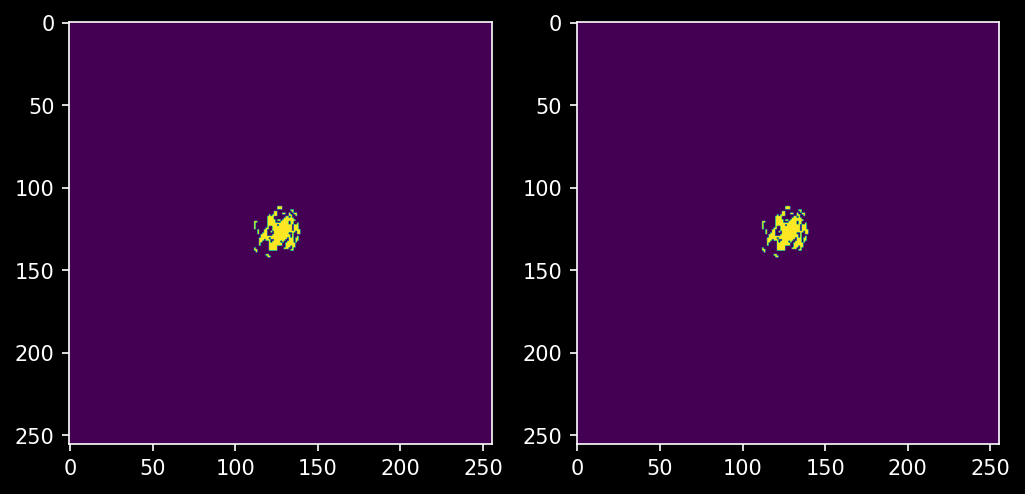

In [69]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

axs[0].imshow(S_count.reshape(img_size, img_size))
axs[1].imshow(np.fft.fftshift(S_std.reshape(img_size, img_size)))

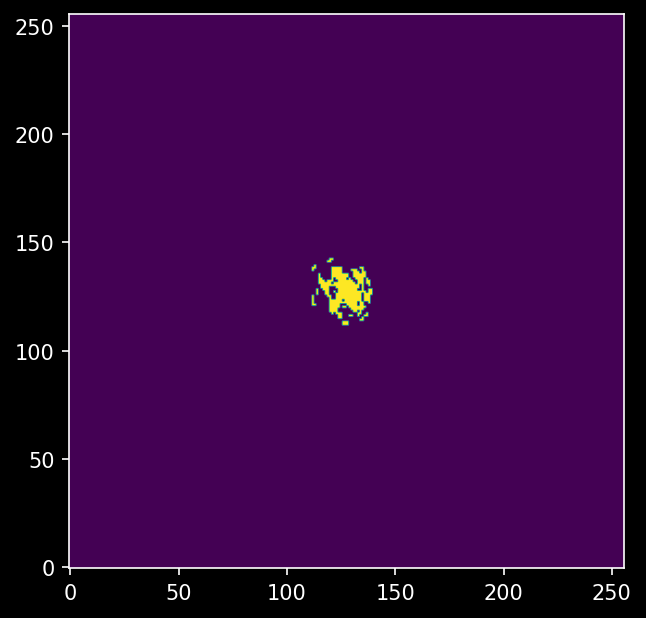

In [34]:
plt.imshow(np.fft.fftshift(S_grid.reshape(img_size, img_size)), origin = "lower")

In [23]:
vis_grid.real.max()

0.061462025318957836

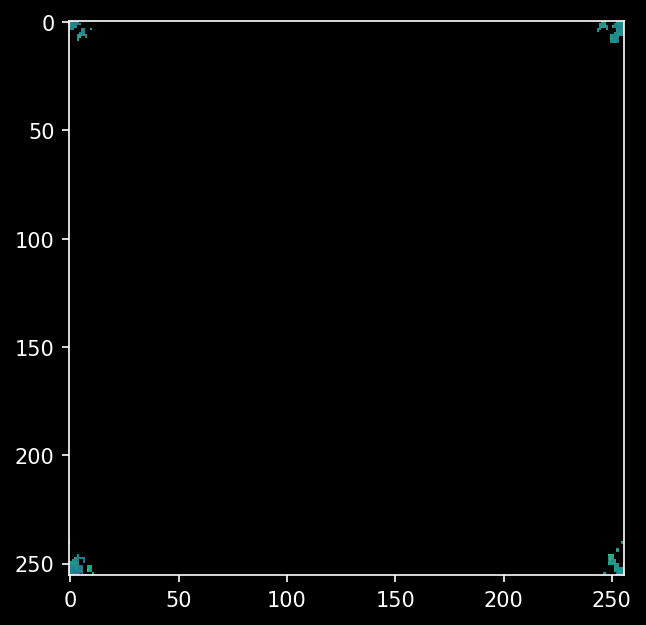

In [28]:
plt.imshow(std_gridded_re.reshape(img_size, img_size))

In [41]:
vis_grid.mean()

(2.063231375540872e-05-1.4509849062735517e-06j)

In [45]:
(std_gridded_re/ (count.flatten() + 1)).mean()

0.00035093002704310967

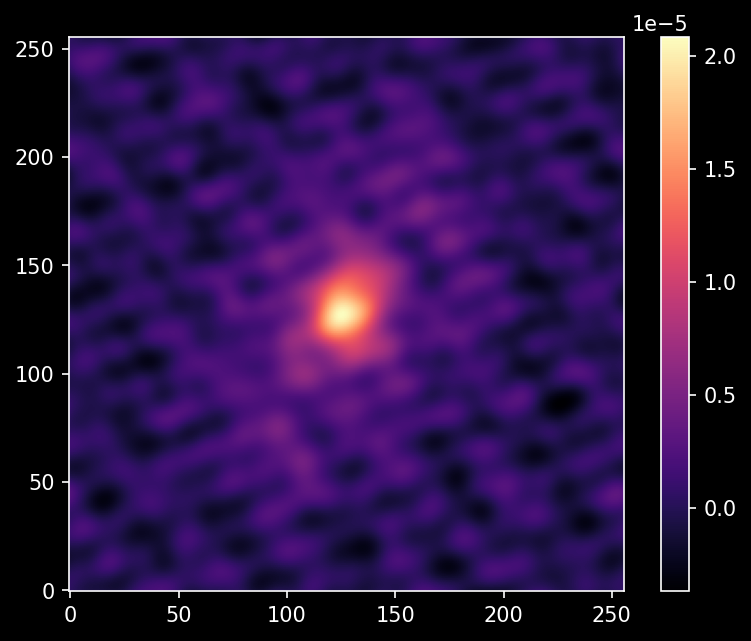

In [36]:
dirty_image = flip(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(vis_grid))))
plt.imshow(dirty_image.real, cmap = "magma", origin = "lower")
plt.colorbar()